In [2]:
import pathlib
import random
from collections import Counter
import os

import pandas as pd

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.vision.data import ImageBlock
from fastai.data.transforms import ColReader, ColSplitter
from fastai.vision.augment import Resize
from fastai.vision.models import resnet34
from fastai.vision.all import vision_learner
from fastai.metrics import accuracy_multi
from fastai.interpret import Interpretation

In [ ]:
if "COLAB_GPU" in os.environ:
  from google.colab import drive
  drive.mount('/content/drive')
  proj_path = pathlib.Path("/content/drive/My Drive/Colab Notebooks/data-viz-code-finder")
else:
  proj_path = pathlib.Path(".")

# Preprocessing

The training data consists of plots from articles in the [R Graph Gallery](https://r-graph-gallery.com/). Each row corresponds to a plot image and the `article` lists the name of the article containing the plot.

In [ ]:
df = pd.read_csv(proj_path/'graph-gallery.csv')
df["function_labels"] = df["function_labels"].fillna('')
df.head()

,article,chunk_name,png_path,code,functions,function_labels
0,1-one-title-for-2-graphs,thecode-1,images/1-one-title-for-2-graphs/thecode-1.png,"#Dummy data \nIxos <- rnorm(4000,100,30)\nPrimadur <- Ixos+rnorm(4000 , 0 , 30)\n \n#Divide the screen in 1 line and 2 columns\npar(\n mfrow=c(1,2), \n oma = c(0, 0, 2, 0)\n) \n \n#Make the margin around each graph a bit smaller\npar(mar=c(4,2,2,2))\n \n# Histogram and Scatterplot\nhist(Ixos, main="""" , breaks=30 , col=rgb(0.3,0.5,1,0.4) , xlab=""height"" , ylab=""nbr of plants"")\nplot(Ixos , Primadur, main="""" , pch=20 , cex=0.4 , col=rgb(0.3,0.5,1,0.4) , xlab=""primadur"" , ylab=""Ixos"" )\n \n#And I add only ONE title :\nmtext(""Primadur : Distribution and correlation with Ixos"", outer = TRU...","<-,rnorm,+,par,c,hist,rgb,plot,mtext",hist
1,1-one-title-for-2-graphs,thecode2-1,images/1-one-title-for-2-graphs/thecode2-1.png,"# Create data\ndata = data.frame(\n x=seq(1:100) + 0.1*seq(1:100)*sample(c(1:10) , 100 , replace=T),\n y=seq(1:100) + 0.2*seq(1:100)*sample(c(1:10) , 100 , replace=T)\n)\n\n# Basic scatterplot\nplot(data$x, data$y,\n xlim=c(0,250) , ylim=c(0,250), \n pch=18, \n cex=2, \n col=""#69b3a2"",\n xlab=""value of X"", ylab=""value of Y"",\n main=""A simple scatterplot""\n )","=,data.frame,+,seq,:,*,sample,c,plot,$",
2,100-high-density-scatterplot-with-binning,thecode-1,images/100-high-density-scatterplot-with-binning/thecode-1.png,"# Packages\nlibrary(hexbin)\nlibrary(RColorBrewer)\n \n# Create data\nx <- rnorm(mean=1.5, 5000)\ny <- rnorm(mean=1.6, 5000)\n \n# Make the plot\nbin<-hexbin(x, y, xbins=40)\nmy_colors=colorRampPalette(rev(brewer.pal(11,'Spectral')))\nplot(bin, main="""" , colramp=my_colors , legend=F ) \n","library,<-,rnorm,hexbin,=,colorRampPalette,rev,brewer.pal,plot",hexbin
3,104-plot-lines-with-error-envelopes-ggplot2,thecode-1,images/104-plot-lines-with-error-envelopes-ggplot2/thecode-1.png,"library(ggplot2)\n \n# Get the data from the web !\nCC <- read.table(""http://www.sr.bham.ac.uk/~ajrs/papers/sanderson06/mean_Tprofile-CC.txt"" , header=TRUE)\nnCC <- read.table(""http://www.sr.bham.ac.uk/~ajrs/papers/sanderson06/mean_Tprofile-nCC.txt"" , header=TRUE)\nCC$type <- ""Cool core""\nnCC$type <- ""Non-cool core""\nA <- rbind(CC, nCC)\n \n \n# Make the plot\nggplot(data=A, aes(x=r.r500, y=sckT, ymin=sckT.lo, ymax=sckT.up, fill=type, linetype=type)) + \n geom_line() + \n geom_ribbon(alpha=0.5) + \n scale_x_log10() + \n scale_y_log10() + \n xlab(as.expression(expression( paste(""Radius ("",...","library,<-,read.table,$,rbind,+,ggplot,aes,geom_line,geom_ribbon,scale_x_log10,scale_y_log10,xlab,as.expression,expression,paste,[,ylab","geom_line,geom_ribbon"
4,115-study-correlations-with-a-correlogram,thecode-1,images/115-study-correlations-with-a-correlogram/thecode-1.png,"# Corrgram library\nlibrary(corrgram)\n\n# mtcars dataset is natively available in R\n# head(mtcars)\n\n# First\ncorrgram(mtcars, order=TRUE, lower.panel=panel.shade, upper.panel=panel.pie, text.panel=panel.txt, main=""Car Milage Data in PC2/PC1 Order"") \n\n# Second\ncorrgram(mtcars, order=TRUE, lower.panel=panel.ellipse, upper.panel=panel.pts, text.panel=panel.txt, diag.panel=panel.minmax, main=""Car Milage Data in PC2/PC1 Order"") \n\n# Third\ncorrgram(mtcars, order=NULL, lower.panel=panel.shade, upper.panel=NULL, text.panel=panel.txt, main=""Car Milage Data (unsorted)"")","library,corrgram",corrgram



To prevent data leakage it's good practice to split the data into training and validation sets at the article level such that all plots from a given article are entirely in the training or entirely in the validation set.

In [ ]:
# Add logical is_valid column to the data to denote training and validation sets
def add_is_valid(df, valid_pct=0.2, seed=8329891):
  random.seed(seed)
  article_values = df['article'].unique()
  random.shuffle(article_values)
  valid_size = int(len(article_values) * valid_pct)
  valid_articles = article_values[:valid_size]
  df['is_valid'] = df['article'].isin(valid_articles)
  return df

The data has a large number of labels, many of which are infrequent. We'll limit the set of labels to the top 30 most frequent labels occurring in the training set. This also ensures that all labels in the validation set appear in the training set.

In [ ]:
def get_vocab(df, n=30):
  split_lists = df.query("is_valid == False")["function_labels"].str.split(",")
  flattened_list = [item for sublist in split_lists for item in sublist if item != ""]
  counts = Counter(flattened_list)
  print("Found the following training labels:")
  print(counts.most_common())
  res = [element for element, _ in counts.most_common(n)]
  return set(res)

def apply_vocab(df, vocab):
  def modify_labels(row):
    labels = row["function_labels"].split(",")
    res = set(labels) & vocab
    return ','.join(res)

  df["function_labels"] = df.apply(modify_labels, axis=1)
  return df

Apply preprocessing steps

In [ ]:
df = add_is_valid(df)
vocab = get_vocab(df)
print(f"Vocab: {vocab}")
df = apply_vocab(df, vocab)

print(f"Train size: {(df['is_valid'] == False).sum()}")
print(f"Validation size: {(df['is_valid'] == True).sum()}")

df.head()

Found the following training labels:
[('geom_point', 54), ('geom_text', 26), ('geom_bar', 26), ('geom_line', 25), ('geom_segment', 20), ('barplot', 16), ('coord_polar', 15), ('facet_wrap', 12), ('geom_polygon', 12), ('text', 11), ('hist', 9), ('geom_area', 9), ('geom_histogram', 9), ('boxplot', 9), ('geom_boxplot', 9), ('lines', 8), ('points', 8), ('geom_label', 7), ('pie', 7), ('geom_hline', 7), ('ggparcoord', 7), ('geom_rect', 6), ('grid.arrange', 6), ('heatmap', 6), ('ggraph', 6), ('geom_violin', 6), ('ggpairs', 5), ('radarchart', 5), ('facet_grid', 5), ('geom_tile', 5), ('geom_vline', 4), ('geom_density', 3), ('xyplot', 3), ('circleProgressiveLayout', 3), ('circleLayoutVertices', 3), ('geom_node_point', 3), ('geom_node_text', 3), ('geom_node_circle', 3), ('geom_errorbar', 3), ('parcoord', 3), ('geom_text_repel', 3), ('grid.lines', 3), ('grid.rect', 3), ('grid.text', 3), ('ggcorr', 2), ('polygon', 2), ('layoutLayer', 2), ('arrow', 2), ('geom_density_ridges', 2), ('geom_conn_bundle',

,article,chunk_name,png_path,code,functions,function_labels,is_valid
0,1-one-title-for-2-graphs,thecode-1,images/1-one-title-for-2-graphs/thecode-1.png,"#Dummy data \nIxos <- rnorm(4000,100,30)\nPrimadur <- Ixos+rnorm(4000 , 0 , 30)\n \n#Divide the screen in 1 line and 2 columns\npar(\n mfrow=c(1,2), \n oma = c(0, 0, 2, 0)\n) \n \n#Make the margin around each graph a bit smaller\npar(mar=c(4,2,2,2))\n \n# Histogram and Scatterplot\nhist(Ixos, main="""" , breaks=30 , col=rgb(0.3,0.5,1,0.4) , xlab=""height"" , ylab=""nbr of plants"")\nplot(Ixos , Primadur, main="""" , pch=20 , cex=0.4 , col=rgb(0.3,0.5,1,0.4) , xlab=""primadur"" , ylab=""Ixos"" )\n \n#And I add only ONE title :\nmtext(""Primadur : Distribution and correlation with Ixos"", outer = TRU...","<-,rnorm,+,par,c,hist,rgb,plot,mtext",hist,False
1,1-one-title-for-2-graphs,thecode2-1,images/1-one-title-for-2-graphs/thecode2-1.png,"# Create data\ndata = data.frame(\n x=seq(1:100) + 0.1*seq(1:100)*sample(c(1:10) , 100 , replace=T),\n y=seq(1:100) + 0.2*seq(1:100)*sample(c(1:10) , 100 , replace=T)\n)\n\n# Basic scatterplot\nplot(data$x, data$y,\n xlim=c(0,250) , ylim=c(0,250), \n pch=18, \n cex=2, \n col=""#69b3a2"",\n xlab=""value of X"", ylab=""value of Y"",\n main=""A simple scatterplot""\n )","=,data.frame,+,seq,:,*,sample,c,plot,$",,False
2,100-high-density-scatterplot-with-binning,thecode-1,images/100-high-density-scatterplot-with-binning/thecode-1.png,"# Packages\nlibrary(hexbin)\nlibrary(RColorBrewer)\n \n# Create data\nx <- rnorm(mean=1.5, 5000)\ny <- rnorm(mean=1.6, 5000)\n \n# Make the plot\nbin<-hexbin(x, y, xbins=40)\nmy_colors=colorRampPalette(rev(brewer.pal(11,'Spectral')))\nplot(bin, main="""" , colramp=my_colors , legend=F ) \n","library,<-,rnorm,hexbin,=,colorRampPalette,rev,brewer.pal,plot",,False
3,104-plot-lines-with-error-envelopes-ggplot2,thecode-1,images/104-plot-lines-with-error-envelopes-ggplot2/thecode-1.png,"library(ggplot2)\n \n# Get the data from the web !\nCC <- read.table(""http://www.sr.bham.ac.uk/~ajrs/papers/sanderson06/mean_Tprofile-CC.txt"" , header=TRUE)\nnCC <- read.table(""http://www.sr.bham.ac.uk/~ajrs/papers/sanderson06/mean_Tprofile-nCC.txt"" , header=TRUE)\nCC$type <- ""Cool core""\nnCC$type <- ""Non-cool core""\nA <- rbind(CC, nCC)\n \n \n# Make the plot\nggplot(data=A, aes(x=r.r500, y=sckT, ymin=sckT.lo, ymax=sckT.up, fill=type, linetype=type)) + \n geom_line() + \n geom_ribbon(alpha=0.5) + \n scale_x_log10() + \n scale_y_log10() + \n xlab(as.expression(expression( paste(""Radius ("",...","library,<-,read.table,$,rbind,+,ggplot,aes,geom_line,geom_ribbon,scale_x_log10,scale_y_log10,xlab,as.expression,expression,paste,[,ylab",geom_line,False
4,115-study-correlations-with-a-correlogram,thecode-1,images/115-study-correlations-with-a-correlogram/thecode-1.png,"# Corrgram library\nlibrary(corrgram)\n\n# mtcars dataset is natively available in R\n# head(mtcars)\n\n# First\ncorrgram(mtcars, order=TRUE, lower.panel=panel.shade, upper.panel=panel.pie, text.panel=panel.txt, main=""Car Milage Data in PC2/PC1 Order"") \n\n# Second\ncorrgram(mtcars, order=TRUE, lower.panel=panel.ellipse, upper.panel=panel.pts, text.panel=panel.txt, diag.panel=panel.minmax, main=""Car Milage Data in PC2/PC1 Order"") \n\n# Third\ncorrgram(mtcars, order=NULL, lower.panel=panel.shade, upper.panel=NULL, text.panel=panel.txt, main=""Car Milage Data (unsorted)"")","library,corrgram",,False


# Training

Create a simple dataloader that collates images and resizes then to 224x224

In [ ]:
blocks = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader("png_path", pref=f"{proj_path}/"),
                   # uses is_valid column by default
                   splitter=ColSplitter(),
                   get_y=ColReader("function_labels", label_delim=","),
                   item_tfms=Resize(224)
                   )

dls = blocks.dataloaders(df)

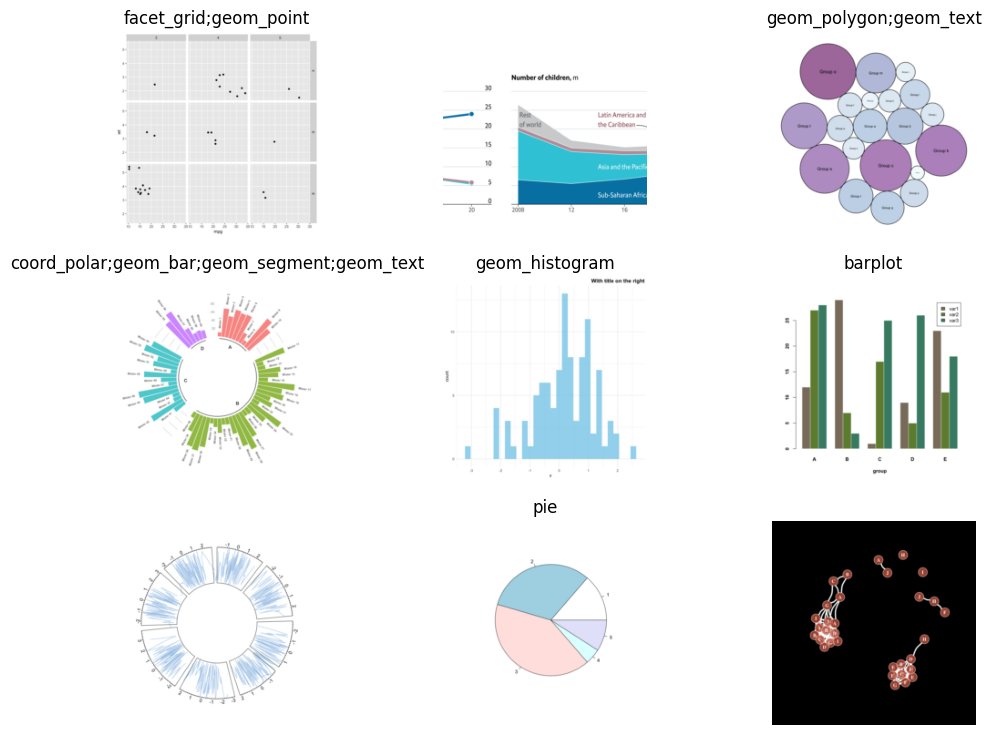

In [ ]:
dls.show_batch(max_n=9, figsize=(12,9))

We'll fine tune a pre-trained resnet model. Our data contains a large number of examples with no label either because source code was not correctly associated with the plot or because the label was excluded due to infrequency. Although this isn't necessarily a problem for training it may make the standard multiclass accuracy measure difficult to interpret. In addition to overall accuracy we'll track accuracy on examples with at least one label.

In [ ]:
# Define custom acc measure
def accuracy_multi_no_zero_class(inp, targ, thresh=0.5, sigmoid=True):
  non_zero_mask = targ.sum(axis=1) > 0
  inp = inp[non_zero_mask]
  targ = targ[non_zero_mask]

  return accuracy_multi(inp, targ, thresh, sigmoid)

learner = vision_learner(dls, resnet34, metrics=[accuracy_multi, accuracy_multi_no_zero_class])
learner.fine_tune(30)
learner.export(proj_path/"model-30.pkl")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi_no_zero_class,time
0,1.061038,1.027431,0.446454,0.448522,00:35


epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi_no_zero_class,time
0,1.014261,0.884294,0.482270,0.488226,00:33
1,1.008595,0.838175,0.492908,0.500370,00:37
2,0.990279,0.819829,0.495745,0.504693,00:32
3,0.973636,0.799998,0.503901,0.514620,00:34
4,0.955918,0.782950,0.516667,0.542265,00:35
5,0.940565,0.754624,0.537943,0.562259,00:33
6,0.923561,0.735712,0.557092,0.567209,00:34
7,0.907746,0.715525,0.565248,0.572839,00:33
8,0.888130,0.683198,0.596454,0.593915,00:35
9,0.870494,0.652380,0.626950,0.630461,00:35


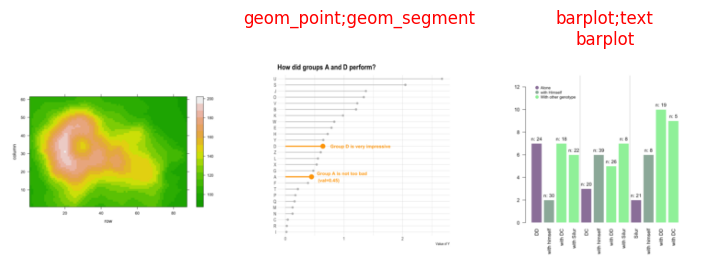

In [ ]:
learner.show_results(max_n=3)

,target,predicted,probabilities,loss
0,,facet_grid;geom_area;radarchart,"tensor([0.2798, 0.1401, 0.3746, 0.5040, 0.3481, 0.5324, 0.1177, 0.4935, 0.1289,\n 0.4543, 0.4251, 0.2286, 0.4917, 0.1152, 0.4823, 0.4276, 0.2490, 0.4380,\n 0.1174, 0.2999, 0.3115, 0.1039, 0.2384, 0.1737, 0.3092, 0.1310, 0.0959,\n 0.2388, 0.5761, 0.3373])",0.3886229395866394
1,geom_line;geom_point;geom_text,geom_point,"tensor([0.1405, 0.1307, 0.3469, 0.2902, 0.3107, 0.3028, 0.1383, 0.2443, 0.2206,\n 0.3542, 0.3020, 0.1242, 0.7552, 0.2014, 0.3441, 0.2332, 0.2024, 0.1566,\n 0.2456, 0.1751, 0.1993, 0.1951, 0.3101, 0.1320, 0.2895, 0.2024, 0.2476,\n 0.2789, 0.2966, 0.2804])",0.38669729232788086
2,ggraph,coord_polar;geom_hline;geom_rect,"tensor([0.1040, 0.2428, 0.6478, 0.1849, 0.4173, 0.1729, 0.1979, 0.1937, 0.1238,\n 0.5330, 0.2611, 0.0579, 0.1345, 0.4389, 0.6082, 0.1958, 0.4977, 0.0754,\n 0.1031, 0.2454, 0.2452, 0.4422, 0.3662, 0.2985, 0.1864, 0.3897, 0.2008,\n 0.4081, 0.1657, 0.4579])",0.37473979592323303
3,,coord_polar;geom_bar,"tensor([0.2065, 0.2939, 0.6188, 0.3083, 0.2619, 0.3138, 0.6636, 0.2584, 0.3842,\n 0.1434, 0.2398, 0.2591, 0.1913, 0.3632, 0.4075, 0.1922, 0.2075, 0.1463,\n 0.3267, 0.1801, 0.2176, 0.3953, 0.1862, 0.2875, 0.3834, 0.3506, 0.2897,\n 0.3401, 0.2709, 0.1583])",0.36781013011932373
4,boxplot,barplot,"tensor([0.9597, 0.2319, 0.2006, 0.2069, 0.1907, 0.2242, 0.0833, 0.2517, 0.1674,\n 0.1323, 0.1893, 0.2235, 0.1176, 0.1989, 0.3233, 0.2528, 0.2263, 0.1756,\n 0.2196, 0.0887, 0.1637, 0.1371, 0.3539, 0.2594, 0.3141, 0.2428, 0.0970,\n 0.1432, 0.1964, 0.2259])",0.3675917387008667


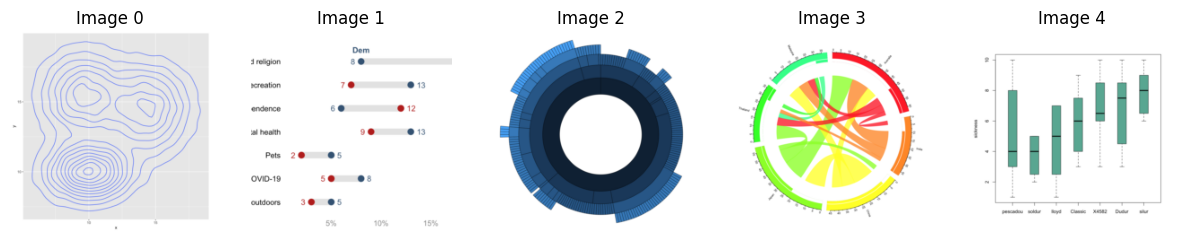

In [ ]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(5, nrows=1)

In [ ]:
learner.fine_tune(30)
learner.export(proj_path/"model-60.pkl")

epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi_no_zero_class,time
0,0.329643,0.269935,0.972695,0.956684,00:36


epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi_no_zero_class,time
0,0.301503,0.259251,0.972340,0.955717,00:32
1,0.295511,0.247869,0.974823,0.957765,00:33
2,0.295674,0.235936,0.976241,0.958248,00:34
3,0.287432,0.223774,0.977660,0.959329,00:35
4,0.275651,0.210150,0.977660,0.960523,00:33
5,0.264311,0.195223,0.977660,0.959442,00:33
6,0.252300,0.169837,0.978723,0.960040,00:35
7,0.239326,0.162561,0.979787,0.958959,00:35
8,0.224699,0.139431,0.978723,0.958959,00:33
9,0.209748,0.133559,0.980142,0.957765,00:34


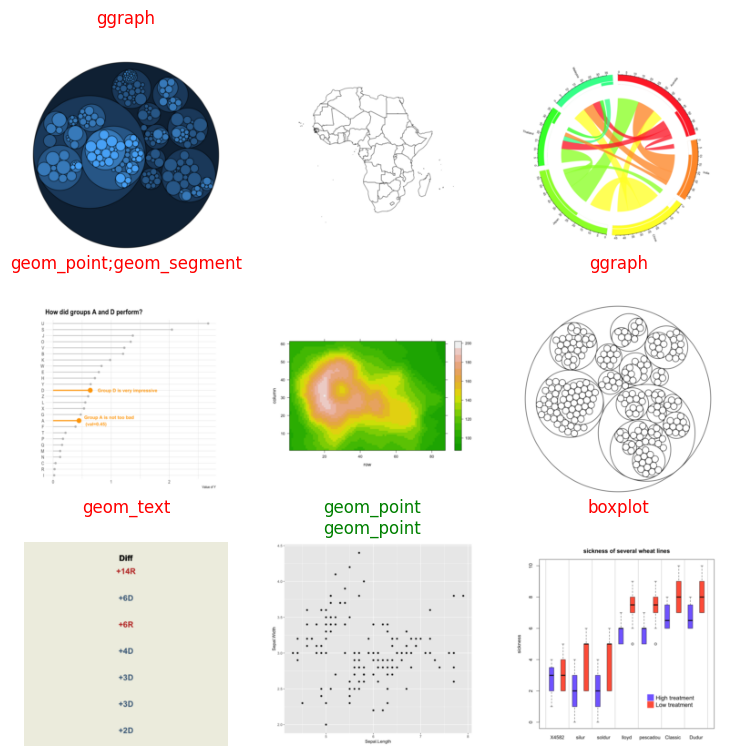

In [ ]:
learner.show_results(max_n=9)

,target,predicted,probabilities,loss
0,geom_line;geom_polygon,,"tensor([0.0090, 0.0068, 0.0463, 0.0061, 0.0136, 0.0278, 0.0126, 0.0407, 0.0092,\n 0.0160, 0.0138, 0.0206, 0.0332, 0.0038, 0.0278, 0.0631, 0.0136, 0.0074,\n 0.0105, 0.0152, 0.0083, 0.0143, 0.0226, 0.0204, 0.0282, 0.0471, 0.0351,\n 0.0473, 0.0251, 0.0317])",0.33731788396835327
1,geom_line;geom_point;geom_text,,"tensor([0.0154, 0.0196, 0.0222, 0.0594, 0.1015, 0.0249, 0.0125, 0.0291, 0.0227,\n 0.0390, 0.0507, 0.0212, 0.3960, 0.0304, 0.0309, 0.0417, 0.0323, 0.0138,\n 0.0202, 0.0265, 0.0185, 0.0201, 0.0521, 0.0178, 0.0327, 0.0394, 0.0303,\n 0.0822, 0.0295, 0.0839])",0.3069181740283966
2,ggraph,,"tensor([0.0070, 0.0025, 0.0037, 0.0069, 0.0114, 0.0183, 0.0046, 0.0033, 0.0052,\n 0.0075, 0.0076, 0.3493, 0.0264, 0.0039, 0.0073, 0.0068, 0.0049, 0.0030,\n 0.0264, 0.0272, 0.0034, 0.0016, 0.0057, 0.0020, 0.0013, 0.0223, 0.0033,\n 0.0136, 0.0088, 0.0057])",0.23769937455654144
3,geom_point;geom_segment,,"tensor([0.0300, 0.0239, 0.0289, 0.0192, 0.0700, 0.0157, 0.0175, 0.0218, 0.0340,\n 0.0830, 0.0360, 0.0348, 0.1566, 0.0325, 0.0339, 0.0353, 0.0824, 0.0173,\n 0.0180, 0.0424, 0.0913, 0.0176, 0.0181, 0.0201, 0.0459, 0.0244, 0.0173,\n 0.0428, 0.0426, 0.0522])",0.20792990922927856
4,geom_line;geom_point,,"tensor([0.0217, 0.0151, 0.0256, 0.0452, 0.0602, 0.0206, 0.0114, 0.0378, 0.0198,\n 0.0287, 0.0688, 0.0164, 0.3517, 0.0246, 0.0321, 0.0378, 0.0162, 0.0229,\n 0.0146, 0.0196, 0.0144, 0.0174, 0.0842, 0.0191, 0.0288, 0.0287, 0.0253,\n 0.0781, 0.0257, 0.0780])",0.20327311754226685


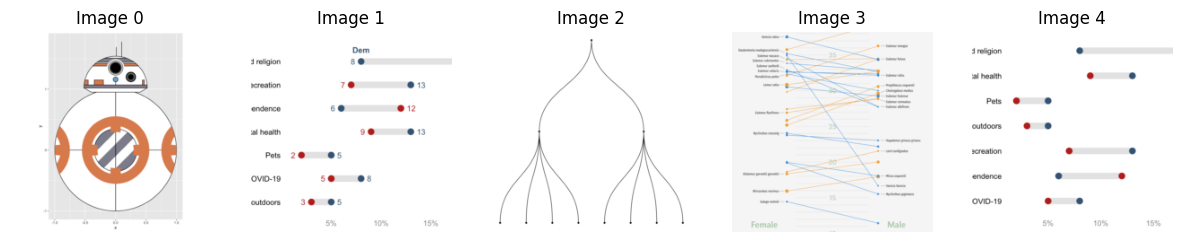

In [ ]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(5, nrows=1)